# Кросс-категорийные продажи P&G в магазинах «Магнит Косметик».


В нашем распряжении два датасета. Датасет "customers" содержит в себе информацию о покупателях, зарегистрированных в системе "Магнит Косметик" через персональную карту. Каждому из этих покупателей приписан уникальный id в  системе. У нас есть информация о возрастной группе, поле покупателя и дате регистрации в системе, канал попадания покупателя в систему "Магнит Косметик". 

Второй датасет "purchases" представляет собой чеки из магазина "Магнит Косметик", в которых есть товар компании P&G. Приобретенная категория товара хранится в столбце "product". Есть информация о цене проданного товара, преобразованная в данные от -1 до 1, ценовой сегмент купленного товара (от "1" - Эконом, до "4" - Премиум), информация о других товарах в чеке (относящихся и не относящихся к P&G).      

Необходимо: 
1. Провести обработку исходных данных и исследовать датасет на наличие определенных последовательностей и трендов. 
2. Составить матрицу кросс-продаж non-food категорий в «Магнит Косметик» и понять, как увеличить рост продаж товаров P&G. 
3. Исходя из анализа данных и взаимосвязи товаров в матрице кросс-продаж, сделать выводы и дать рекомендации по повышению объема продаж с учетом выявленных закономерностей.

### 1. Выгрузка и первичная обработка данных

In [1]:
# загрузка библиотек
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats
import csv
import seaborn as sns
import mlxtend.frequent_patterns 
import mlxtend.preprocessing

In [2]:
# загружаем данные из файла purchases - покупки 
purchases = pd.read_csv('C:\\Users\\Пользователь\\Desktop\\it\\png_magnit_purchases.csv')

In [3]:
# первые 5 строк данных "покупки"
purchases.head(5)

,purchase date,customer,product,other_product,p&g_product,cost_product,cost_p&g,product_segment,p&g_segment
0,2021-12-05,46501ab5e1d554f1a40c,Бумажные салфетки,1.0,0.0,0.719656,NaN,2.0,NaN
1,2021-11-29,fe4b24b8d77d1ac3990f,Мыло кусковое,5.0,0.0,-0.612290,NaN,3.0,NaN
2,2021-01-26,ed14e760a20f500bbbeb,Упаковка подарков,1.0,0.0,0.034713,NaN,3.0,NaN
3,2021-12-02,06337c560d6052ab73e4,Соли для душа,1.0,0.0,-0.468906,NaN,3.0,NaN
4,2021-03-03,92d6c8144600df232b8e,Маски для лица,1.0,0.0,4.273955,NaN,3.0,NaN


Мы видим отсутствующие значения в первых пяти строках столбцов "cost_p&g" и "p&g_segment", так как в этих чеках значится только один купленный продукт P&G, отраженный в столбце "product". Информация о его стоимости предоставлена в столбцах "cost_product" (цена товара), "product_segment" (сегмент товара). Если бы в столбце "p&g_product" была бы отражена информация о еще одном купленном товаре P&G, данные в столбцах "cost_p&g" и "p&g_segment" могли бы быть заполнены.   

In [4]:
# убедимся в верности гипотезы выше: столбцы "p&g_segment" и "cost_p&g" 
# содержат в себе информацию только тогда, когда "p&g_product" не равен нулю.  
# purchases[(purchases['p&g_segment'].notna()) & (purchases['p&g_product']< 1)].head(10) 
# в данных нет строк, которые одновременно были бы пустыми в "p&g_product" и содержали информацию в "p&g_segment"
# это же работает и в обратную сторону:
# purchases[(purchases['p&g_product'].notna()) & (purchases['p&g_segment']< 1)].head(10) 

In [5]:
#проверим, что отражает информация в данных о сегменте дополнительного купленного товара P&G ("p&g_segment"), если в чеке указано ("p&g_product"), что куплено несколько товаров P&G
# purchases[purchases['p&g_product'] > 1].head(10)
# столбец "p&g_segment" не оказался пустым, однако мы не можем знать наверняка, к какому из двух и более дополнительных купленных товаров в чеке ("p&g_product") относятся данные по сегменту ("p&g_segment")  

In [6]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14441625 entries, 0 to 14441624
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   purchase date    object 
 1   customer         object 
 2   product          object 
 3   other_product    float64
 4   p&g_product      float64
 5   cost_product     float64
 6   cost_p&g         float64
 7   product_segment  float64
 8   p&g_segment      float64
dtypes: float64(6), object(3)
memory usage: 991.6+ MB


В данных "покупки" ("purchases") сохранено 14 млн 441 тыс. 625 строк с уникальными чеками.   

In [7]:
# можем убедиться, что товары из столбца ['product'] не разделены по сегментам
# purchases[(purchases['product'] == 'Бумажные салфетки')].sort_values(by = 'product_segment')
# purchases[(purchases['product'] == 'Мыло кусковое')].sort_values(by = 'product_segment')

In [8]:
# узнаем, есть ли у нас в данных выбросы по типам данных: в данных не может быть куплены дробное число товаров, не может быть дробное число категории сегмента
# уникальные значения столбцов дадут нам представление о необходимости удалить данные 
purchases['other_product'].unique()

array([ 1.,  5.,  0.,  3.,  4.,  2.,  9.,  8.,  6.,  7., 13., 10., 12.,
       14., 17., 11., 16., 19., 15., 18., 28., 20., 23., 21., 22., 25.,
       32., 24., 26., 30., 27., 31., 29., 37., 36., 34., 38.])

In [9]:
purchases['p&g_product'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  8.,  6.,  7., 11.])

In [10]:
purchases['product_segment'].unique()

array([2.      , 3.      , 4.      ,      nan, 3.5     , 3.666666,
       3.833333, 3.75    , 1.      , 3.333333, 3.25    , 3.90909 ,
       3.8     , 3.6     , 3.4     , 3.714285, 3.571428, 3.888888,
       3.857142, 3.2     , 3.222222, 3.875   , 3.777777, 3.9     ,
       3.727272, 3.428571, 3.285714, 3.866666, 3.166666, 3.636363,
       3.7     , 3.625   , 3.705882, 3.142857, 3.916666, 3.444444,
       3.583333, 3.181818, 3.8125  ])

In [11]:
# посчитаем, сколько у нас строк до удаления 
purchases['product_segment'].count()

13173586

In [12]:
# удалим из таблицы строки с дробными числами в столбце сегмента
allowedseg = [1,2,3,4, np.nan]
purchases = purchases.loc[purchases['product_segment'].isin(allowedseg)]

In [13]:
# посчитаем, сколько у нас строк после удаления 
purchases['product_segment'].count()

13154434

In [14]:
print (f'Процент удаленных дробных данных: {1-(13154434/13173586):.2%}')

Процент удаленных дробных данных: 0.15%


In [15]:
# проверка
purchases['product_segment'].unique()

array([ 2.,  3.,  4., nan,  1.])

In [16]:
purchases['p&g_segment'].unique()

array([nan,  3.,  2.])

In [17]:
# если отсутствующих данных немного в датасете, их можно безболезненно удалить
# посчитаем проценты nan в данных
print(f"Процент пропущенных значений в столбце 'product_segment': {purchases['product_segment'].isna().sum()/len(purchases['product_segment']):.1%}")

Процент пропущенных значений в столбце 'product_segment': 8.8%


In [18]:
# удалим пропущенные значения в 'product_segment'
purchases = purchases.dropna(subset= ['product_segment']).reset_index()

In [19]:
print(f"Процент пропущенных значений в столбце 'p&g_segment': {purchases['p&g_segment'].isna().sum()/len(purchases['product_segment']):.1%}")

Процент пропущенных значений в столбце 'p&g_segment': 99.2%


In [20]:
#преобразуем где возможно данные в необходимые для вычислений и обработки формат int и datetime
purchases['other_product'] = purchases['other_product'].astype("int")
purchases['p&g_product'] = purchases['p&g_product'].astype("int")
purchases['purchase date'] = pd.to_datetime(purchases['purchase date'])
purchases['product_segment'] = purchases['product_segment'].astype("int")

In [21]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13154434 entries, 0 to 13154433
Data columns (total 10 columns):
 #   Column           Dtype         
---  ------           -----         
 0   index            int64         
 1   purchase date    datetime64[ns]
 2   customer         object        
 3   product          object        
 4   other_product    int32         
 5   p&g_product      int32         
 6   cost_product     float64       
 7   cost_p&g         float64       
 8   product_segment  int32         
 9   p&g_segment      float64       
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), object(2)
memory usage: 853.1+ MB


In [22]:
#проверим, есть ли в данных явные дубликаты
print(f"В данных обнаружено {purchases.duplicated().sum()} дубликатов")

В данных обнаружено 0 дубликатов


In [23]:
# проверим наличие скрытых дубликатов, например, за счет разны названий одной и той же категории продукта в столбце "product"
# также ознакомимся с предоставленными категориями товаров
#display(purchases['product'].unique())

In [24]:
# в столбце "cost_product" должны быть числа от -1 до 1. посчитаем количество аномальных данных (больше 1 или меньше -1)
print (f"Количество аномальных данных в столбце 'cost_product': {purchases[(purchases['cost_product']>1) | (purchases['cost_product']< -1) ]['cost_product'].count()}")

Количество аномальных данных в столбце 'cost_product': 2474501


In [25]:
print (f"Количество аномальных данных в столбце 'cost_product': {(2474501/len(purchases['cost_product'])):.2%}" ) 

Количество аномальных данных в столбце 'cost_product': 18.81%


В данных обнаружено 2 млн 474 тыс 501 данных, в которых 'cost_product' выходит за рамки -1 до 1. Это почти 19% от всех данных. Мы не можем удалить эти данные, так как это может нарушить статистический баланс при исследовании иных характеристек покупок. Данные необходимо будет удалить только в случае исследовании цен на продукты.

In [26]:
# какого числа были совершены самые ранние покупки в чеках
purchases['purchase date'].sort_values().head(3) 

7498764    2021-01-01
10115667   2021-01-01
12704511   2021-01-01
Name: purchase date, dtype: datetime64[ns]

In [27]:
# какого числа были совершены самые поздние покупки в чеках
purchases['purchase date'].sort_values().tail(3) 

12581365   2021-12-31
12062964   2021-12-31
6137717    2021-12-31
Name: purchase date, dtype: datetime64[ns]

<b> Общий вывод по предобработке данных датасета "покупки" - "purchases": </b>

1!) В данных обнаружено 18.81 % аномальных данных, в которых 'cost_product' выходит за рамки -1 до 1. Принято решение оставить данные, чтобы не потерять остальную важную информацию в чеке. 

2!) Процент пропущенных значений в столбце 'product_segment' - 8.8%, присутствовали дробные значения(0.15%). Эти данные удалены.

3!) Нет информации о том, к какому из двух и более дополнительных купленных товаров в чеке ("p&g_product") относятся данные по сегменту ("p&g_segment"). 

4.) Размер данных до обработки 14441624 строк и 9 столбцов. После первичной обработки 13154434 строк и 9 столбцов.  
В данных не обнаружены дубликаты скрытые и явные. Где возможно, данные приведены к стандартному типу данных int и datetime. В данных много пропусков в столбцах "cost_p&g" и "p&g_segment", что объясняется тем, что эти заполнены только в тех чеках, где был куплен дополнительный товар p&g. Данные в чеках представлены за год: с 1 января 2021 года до 31 декабря 2021 года. 

In [28]:
# загружаем данные из файла customers - покупатели
customers = pd.read_csv('C:\\Users\\Пользователь\\Desktop\\it\\png_magnit_customers.csv')

In [29]:
# первые 5 строк данных "покупатели"
customers.head(5)

,customer,customer_age_group,gender,enr_channel,enr_date
0,e0efeacbbbbc72f53a0c,[21 - 25],F,SMS,2019-10-27
1,3211c12941b73356a68e,[36 - 40],F,Mobile App,2019-11-02
2,4c2c6c4175dc9a75e134,[51 and more],U,Mobile App,2019-11-01
3,2698e403385bf0e02553,[31 - 35],F,Mobile App,2019-10-25
4,5580c83260e4a918965e,[26 - 30],F,SMS,2019-10-27


In [30]:
# общая информация о данных "покупатели"
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352547 entries, 0 to 352546
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   customer            352547 non-null  object
 1   customer_age_group  351951 non-null  object
 2   gender              352547 non-null  object
 3   enr_channel         352547 non-null  object
 4   enr_date            352547 non-null  object
dtypes: object(5)
memory usage: 13.4+ MB


In [31]:
# пропущенных данных немного, можем их удалить
customers = customers.dropna(axis = 0) 

In [32]:
# наличие явных дубликатов
display(customers.duplicated().sum())

0

In [33]:
# тип данных 
customers['enr_date'] = pd.to_datetime(customers['enr_date'])

In [34]:
# уникальные значения групп возраста покупателей в системе "магнит косметик"
customers['customer_age_group'].value_counts().sort_values(ascending = False)

[51 and more]    79499
[31 - 35]        55574
[36 - 40]        51297
[26 - 30]        44295
[21 - 25]        42398
[41 - 45]        40217
[46 - 50]        29813
[18 - 20]         8858
Name: customer_age_group, dtype: int64

In [35]:
# уникальные значения групп пола покупателей в системе "магнит косметик"
customers['gender'].value_counts().sort_values(ascending = False)

F    219338
M    100723
U     31890
Name: gender, dtype: int64

In [36]:
print(f"Процент покупателей с неопределенным полом в данных: {31890/ customers['gender'].count():.2%}")

Процент покупателей с неопределенным полом в данных: 9.06%


In [37]:
# униклаьные значения групп источника регистраци покупателей в системе "магнит косметик"
customers['enr_channel'].value_counts().sort_values(ascending = False)

SMS                    178661
Mobile App             120511
Customer Web Portal     31576
Back Office             12122
Koshelok                 6106
Batch File               2975
Name: enr_channel, dtype: int64

In [38]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351951 entries, 0 to 352546
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer            351951 non-null  object        
 1   customer_age_group  351951 non-null  object        
 2   gender              351951 non-null  object        
 3   enr_channel         351951 non-null  object        
 4   enr_date            351951 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 16.1+ MB


<b> Общий вывод по предобработке данных датасета "покупатели" - "customers":</b>

В данных процент покупателей с неопределенным полом 9%. В данных удалены пропуски, преобразован тип данных. Отсутствуют скрытые дубликаты. После обработки в данных 351951 строки, 5 столбцов.        

Для работы с данными объединим таблицы "покупателей" - "customers" и совершенных покупок - "purchases" в общую таблицу "data". 

In [39]:
# объединим таблицы с приоритетом чеков, покупок 'purchases'
data = customers.merge(right = purchases, on='customer', how='right') 

In [40]:
data = data [['customer', 'customer_age_group', 'gender', 'enr_channel', 'enr_date', 'purchase date', 'product', 'other_product', 'p&g_product',
       'cost_product', 'cost_p&g', 'product_segment', 'p&g_segment']]
display(data.head(5))

,customer,customer_age_group,gender,enr_channel,enr_date,purchase date,product,other_product,p&g_product,cost_product,cost_p&g,product_segment,p&g_segment
0,46501ab5e1d554f1a40c,[51 and more],M,Mobile App,2019-11-01,2021-12-05,Бумажные салфетки,1,0,0.719656,NaN,2,NaN
1,fe4b24b8d77d1ac3990f,[31 - 35],M,SMS,2019-11-07,2021-11-29,Мыло кусковое,5,0,-0.612290,NaN,3,NaN
2,ed14e760a20f500bbbeb,[21 - 25],F,SMS,2019-12-14,2021-01-26,Упаковка подарков,1,0,0.034713,NaN,3,NaN
3,06337c560d6052ab73e4,[31 - 35],F,SMS,2020-06-16,2021-12-02,Соли для душа,1,0,-0.468906,NaN,3,NaN
4,92d6c8144600df232b8e,[31 - 35],F,Customer Web Portal,2020-05-24,2021-03-03,Маски для лица,1,0,4.273955,NaN,3,NaN


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13154434 entries, 0 to 13154433
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   customer            object        
 1   customer_age_group  object        
 2   gender              object        
 3   enr_channel         object        
 4   enr_date            datetime64[ns]
 5   purchase date       datetime64[ns]
 6   product             object        
 7   other_product       int32         
 8   p&g_product         int32         
 9   cost_product        float64       
 10  cost_p&g            float64       
 11  product_segment     int32         
 12  p&g_segment         float64       
dtypes: datetime64[ns](2), float64(3), int32(3), object(5)
memory usage: 1.2+ GB


### 2. Первичный анализ данных

Данные "data" представляют собой чеки покупателей, в которых куплен товар P&G, с информацией об этих покупателях (возраст, гендер, канал регистрации в "магнит косметик", дата регистрации. 
Чеки представляют собой покупки за 2021 год. 
Узнаем, кто совершил хотя бы одну покупку P&G продуктов в "Магнит косметик" за 2021 год. 

In [42]:
display(data.head(5))

,customer,customer_age_group,gender,enr_channel,enr_date,purchase date,product,other_product,p&g_product,cost_product,cost_p&g,product_segment,p&g_segment
0,46501ab5e1d554f1a40c,[51 and more],M,Mobile App,2019-11-01,2021-12-05,Бумажные салфетки,1,0,0.719656,NaN,2,NaN
1,fe4b24b8d77d1ac3990f,[31 - 35],M,SMS,2019-11-07,2021-11-29,Мыло кусковое,5,0,-0.612290,NaN,3,NaN
2,ed14e760a20f500bbbeb,[21 - 25],F,SMS,2019-12-14,2021-01-26,Упаковка подарков,1,0,0.034713,NaN,3,NaN
3,06337c560d6052ab73e4,[31 - 35],F,SMS,2020-06-16,2021-12-02,Соли для душа,1,0,-0.468906,NaN,3,NaN
4,92d6c8144600df232b8e,[31 - 35],F,Customer Web Portal,2020-05-24,2021-03-03,Маски для лица,1,0,4.273955,NaN,3,NaN


In [43]:
# чеки в разных возрастных группах 
data['customer_age_group'].value_counts().sort_values(ascending = False)

[51 and more]    2966247
[31 - 35]        2174658
[36 - 40]        2135196
[41 - 45]        1655399
[26 - 30]        1524191
[21 - 25]        1285748
[46 - 50]        1179419
[18 - 20]         211931
Name: customer_age_group, dtype: int64

In [44]:
# покупки людей разного гендера
data['gender'].value_counts().sort_values(ascending = False)

F    9327130
M    2713993
U    1091666
Name: gender, dtype: int64

In [45]:
# способ регистрации в системе "Магнит-косметик" 
data['enr_channel'].value_counts().sort_values(ascending = False)

SMS                    7092865
Mobile App             4233289
Customer Web Portal    1170406
Back Office             473868
Koshelok                 88103
Batch File               74258
Name: enr_channel, dtype: int64

In [46]:
# топ-30 самых покупаемых товаров в чеках
data['product'].value_counts().sort_values(ascending = False).head(30) 

Туалетная бумага                           599948
Хозяйственные товары для уборки            452007
Пасты зубные                               392917
Влажные корма для кошек и котят            348507
Шампуни                                    328159
Чулочно-носочные изделия                   309642
Краска для волос                           309139
Ватная продукция                           302008
Влажные салфетки                           295728
Дезодоранты женские                        294830
Чистящие средства                          287994
Мыло жидкое                                253888
Мыло кусковое                              236161
Сухие корма для кошек и котят              219503
Женские гели                               216727
Бумажные салфетки                          205546
Ополаскиватели для белья                   203557
Для глаз                                   196122
Прокладки                                  189656
Для губ                                    187241


<div class="alert alert-block alert-warning">
<b> Обнаружены противоречия в данных. Требуется консультация с инженером данных. </b>
(Информация, размышления, комментарии представлены ниже)
</div>

Если человек купил в один день три товара P&G, будет ли это отражено в данных как три разных строки, либо это будет отражено как одна строка - один чек? Проверим.   

In [47]:
# выведем информацию о покупателе, у которого информация в столбце p&g_product - 4 продукта: 
data[data["p&g_product"] == 4 ].head(1) 

,customer,customer_age_group,gender,enr_channel,enr_date,purchase date,product,other_product,p&g_product,cost_product,cost_p&g,product_segment,p&g_segment
38834,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Подгузники,1,4,1.009199,4.286732,3,3.0


In [48]:
# теперь изучим, сколько этот человек купил товаров в один день, сколько строк к нему относится:   
data[(data["customer"] == "e2a09da6b7ecd1bef2c1" ) & (data["purchase date"] == "2021-05-22")]

,customer,customer_age_group,gender,enr_channel,enr_date,purchase date,product,other_product,p&g_product,cost_product,cost_p&g,product_segment,p&g_segment
38834,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Подгузники,1,4,1.009199,4.286732,3,3.0
344635,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Покрывала,1,0,-0.086752,NaN,4,NaN
893804,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Зубные щетки и насадки,1,1,-0.906314,-0.395008,3,3.0
1645132,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Наполнители,1,0,3.190346,NaN,3,NaN
3258819,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Хозяйственные товары для уборки,1,0,-0.735308,NaN,4,NaN
3389429,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Упаковка для выпечки и хранения продуктов,2,0,-0.188076,NaN,4,NaN
6202893,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Товары для ванной,1,0,-0.091050,NaN,4,NaN
6638268,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Товары для чистки/уборки,1,0,-0.748478,NaN,4,NaN
7057012,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Влажные салфетки,1,0,-0.647407,NaN,2,NaN
10755145,e2a09da6b7ecd1bef2c1,[21 - 25],U,Mobile App,2020-07-29,2021-05-22,Скрабы и пилинги,1,0,0.151023,NaN,3,NaN


Мы видим, что здесь подозрительно много "чеков" (если мы считаем 1 строка = один чек) на одного человека в один день, а также число 4 в столбце не соответвует количеству купленных P&G товаров в этот день (если мы считаем, что представленные строки относятся только к одному чеку). Так что из себя представляет каждая строка? Один отдельный чек? Или отдельный P&G товар из чека? Возможно, мы сможем ответить на вопрос, посчитав, сколько в наших данных приходится чеков на одного покупателя в один день.  

In [49]:
# создадим строку с индексами чеков
data['index_bill'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
groupedpс = data.groupby(['purchase date', 'customer']).agg({"index_bill":'count'}).reset_index()

In [50]:
# количество чеков на одного человека в один день
groupedpс['index_bill'].value_counts().head(10)

1     1378804
2     1065101
3      705240
4      448301
5      282066
6      179306
7      116448
8       76558
9       51535
10      34837
Name: index_bill, dtype: int64

In [51]:
# посчитаем процентное соотношение чеков: 
groupedpс['index_bill'].quantile([0.01, 0.25, 0.5, 0.75, 0.95, 0.99])

0.01     1.0
0.25     1.0
0.50     2.0
0.75     4.0
0.95     8.0
0.99    12.0
Name: index_bill, dtype: float64

У 50 процентов наших данных: это больше чем два строки на одного человека в один день. (следовательно, два чека в один день у 50% покупателей, если мы считаем, что чек - это одна строка). Тогда у 25% покупателей в один день 4 чека (если чек - это одна строка). Конечно, можно сказать, что один и тот же покупатель несколько раз в день заходит в магазин и покупает товары, но тогда получится, что у нас 25% покупателей заходят в магазин по 4 раза в день(хоть и не каждый день). Логичным кажется предположить, что данные, представленные нам - это не каждый отдельный чек, а данные по каждому отдельному товару P&G. И несколько строк в данных могут принадлежать к одному чеку. Однако тогда возникает другая проблема. Если мы сгруппировали данные по покупателю и дате (как если бы это был один чек) - (один покупатель - в один день совершает одну покупку - должен быть один чек в строке), то мы ожидаем увидеть, что количество "other_product" и "p&g_product" будет одинаковым для каждой строки, однако в данных это не так. Демонстрация ниже:

In [52]:
# начнем с удаления столбца index_bill, так как он не отражает действительно уникальные чеки  
data = data.drop('index_bill', 1)

In [53]:
# сcheck = data.groupby(['purchase date', 'customer'])
# требуется слишком много памяти, чтобы открыть таблицу (и полностью посмотреть информацию)
# сcheck.apply(display).head(30)

Так, например, у нас есть покупательница "00187df32ea47dc11b19", которая 1 января купила: прокладки, набор подарочный косметический женский, интерьерные украшения и маски для лица. При этом у нее количество P&G продуктов остается 0 (хотя мы уже выяснили, что в "product" отражаются - P&G продукты). Либо покупательница 4 раза зашла в магазин и купила разные товары, либо если все это была одна покупка, значит, у нее должно было в P&G отражаться 3 товара. И количество товаров в чеке other_product - должно быть одинаковым. Что не так в нашем датасете.  

In [54]:
data[(data['customer'] == "00187df32ea47dc11b19") & (data['purchase date'] == "2021-01-01")]

,customer,customer_age_group,gender,enr_channel,enr_date,purchase date,product,other_product,p&g_product,cost_product,cost_p&g,product_segment,p&g_segment
820729,00187df32ea47dc11b19,[41 - 45],F,SMS,2019-11-09,2021-01-01,Прокладки,1,0,-1.053834,NaN,2,NaN
923113,00187df32ea47dc11b19,[41 - 45],F,SMS,2019-11-09,2021-01-01,Наборы подарочные косметические женские,2,0,-0.213984,NaN,2,NaN
2665363,00187df32ea47dc11b19,[41 - 45],F,SMS,2019-11-09,2021-01-01,Маски для лица,2,0,-0.751108,NaN,3,NaN
2716153,00187df32ea47dc11b19,[41 - 45],F,SMS,2019-11-09,2021-01-01,Интерьерные украшения,1,0,-0.877924,NaN,4,NaN


Что нам делать с разнородными противоречивыми данными? Для учебных целей мы предположим, что самое большое количество других продуктов("other_product"), указанное в одном чеке одного человека, - это и есть количество не-P&G продуктов в чеке этого человека. В то время как столбц "p&g_product" и "p&g_segment" вообще не дает нам информации о купленных товарах, если мы уже сгруппировали чеки, и видим купленные P&G товары в столбце "product".  

In [55]:
# создадим таблицу с уникальными чеками, в которых покупатель покупает несколько продуктов
check = data.groupby(['purchase date', 'customer']).agg({"product":'count', 'other_product':'max', 'p&g_product':'max'}).reset_index()

# 3. Анализ данных

Рассмотрим, как часто покупают продукты P&G и не-P&G с помощью графиков боксплот

(0.0, 10.0)

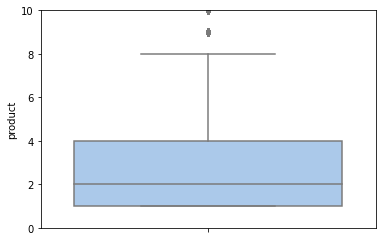

In [56]:
# график боксплот по общему числу продуктов p&g
sns.set_palette('pastel') 
sns.boxplot(y=check["product"])
plt.ylim(0, 10) 

(0.0, 16.0)

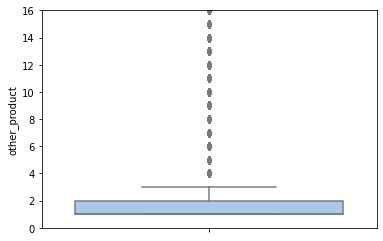

In [57]:
#график боксплот по общему числу продуктов не - p&g в чеках
sns.boxplot(y=check["other_product"])
plt.ylim(0, 16)

In [58]:
check['product'].quantile([0.01, 0.25, 0.5, 0.75, 0.95, 0.99])

0.01     1.0
0.25     1.0
0.50     2.0
0.75     4.0
0.95     8.0
0.99    12.0
Name: product, dtype: float64

Меньше 5% товаров в чеках содержат больше 8 товаров P&G. Удалим эти выбросы. 

In [59]:
check['other_product'].quantile([0.01, 0.25, 0.5, 0.75, 0.95, 0.99])

0.01    1.0
0.25    1.0
0.50    1.0
0.75    2.0
0.95    3.0
0.99    5.0
Name: other_product, dtype: float64

Меньше 5% товаров в чеках содержат больше 8 товаров P&G. Удалим эти выбросы. 

In [60]:
# избавимся от выбросов
check = check[check['other_product'] < 4]
check = check[check['product'] < 8]

In [61]:
# создадим общее количество товаров в столбце total 
check['total'] = check['product'] + check['other_product']

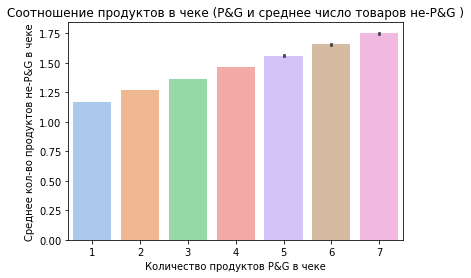

In [62]:
fig = sns.barplot(x = 'product', y = 'other_product', data = check, estimator=np.mean)
plt.xlabel("Количество продуктов P&G в чеке")
plt.ylabel("Среднее кол-во продуктов не-P&G в чеке")
plt.title("Соотношение продуктов в чеке (P&G и среднее число товаров не-P&G )") 
plt.show(fig)

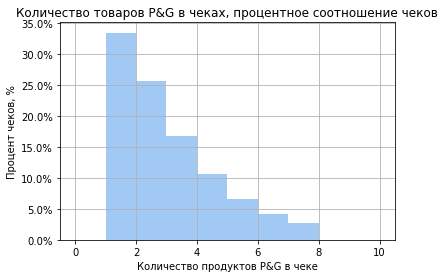

In [63]:
plt.hist(check['product'], weights=np.ones(len(check['product'])) / len(check['product']), range = (0, 20),bins=[0, 1, 2, 3, 4, 5, 6,7,8,9,10])
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Количество товаров P&G в чеках, процентное соотношение чеков') 
plt.xlabel("Количество продуктов P&G в чеке")
plt.ylabel("Процент чеков, %")
plt.show()

Создадим таблицу, в которой представлены не данные по покупкам, а чеки c полной информацией о купленных товарах и информацией о покупателях. 

In [64]:
checks = check.merge(right = customers, on='customer', how='left') 
#checks 

In [65]:
checks

,purchase date,customer,product,other_product,p&g_product,total,customer_age_group,gender,enr_channel,enr_date
0,2021-01-01,0008953dbc5953295be0,1,1,0,2,[26 - 30],F,SMS,2020-09-12
1,2021-01-01,00187df32ea47dc11b19,4,2,0,6,[41 - 45],F,SMS,2019-11-09
2,2021-01-01,0046501ed1ef6caca36e,2,1,0,3,[31 - 35],M,Mobile App,2019-10-25
3,2021-01-01,006c1fd27cd3eec956d6,2,1,0,3,[46 - 50],U,Mobile App,2020-03-14
4,2021-01-01,00a4706b922f66bc2d0b,2,1,0,3,[31 - 35],M,Mobile App,2019-11-03
...,...,...,...,...,...,...,...,...,...,...
4041987,2021-12-31,fff4c6f39c08a9cb5b55,2,2,0,4,[36 - 40],F,Mobile App,2019-10-28
4041988,2021-12-31,fff5a4b98e96b4363e5e,1,1,0,2,[26 - 30],M,Batch File,2020-10-10
4041989,2021-12-31,fff652b6e52c0778c2de,2,2,1,4,[51 and more],F,SMS,2019-11-05
4041990,2021-12-31,fff99802e958caf47ceb,7,1,0,8,[36 - 40],F,Customer Web Portal,2019-10-31


In [66]:
# посчитаем число уникальных покупателей продукции P&G по их половозрастному составу. для этого вычленим из нашей таблицы с чекми только уникальных покупателей
checksun = pd.DataFrame(check['customer'].unique())
checksun.columns = ['customer']
checksun = checksun.merge(right = customers, on='customer', how='left') 

gender,F,M,U,total
customer_age_group,,,,
[51 and more],57579,14997,4623,77199
[46 - 50],19918,6740,2238,28896
[41 - 45],26144,9609,3257,39010
[36 - 40],32526,12870,4394,49790
[31 - 35],32748,16142,5010,53900
[26 - 30],22162,15858,4733,42753
[21 - 25],17981,17871,4943,40795
[18 - 20],5284,1648,1574,8506


Text(0.5, 1.0, "Соотношение возрастных групп и гендеров покупателей p&g продуктов в 'Магнит Косметик'")

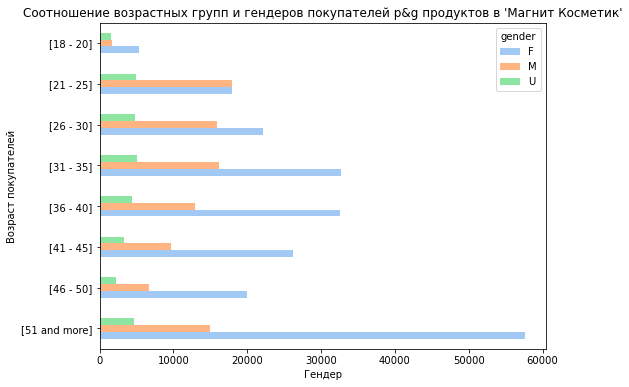

In [67]:
report = checksun.pivot_table(index = 'customer_age_group', columns = 'gender', values = 'customer', aggfunc = 'nunique')
report['total'] = report['F'] + report['M']+ report['U']
report = report.sort_values('customer_age_group', ascending = False)
display(report)
report[['F', 'M', 'U']].plot(kind = 'barh', figsize = (8, 6))
plt.ylabel("Возраст покупателей")
plt.xlabel("Гендер")
plt.title ("Соотношение возрастных групп и гендеров покупателей p&g продуктов в 'Магнит Косметик'")

Отражает ли этот график половозростные особенности покупателей P&G продукции, либо это распределение стандартно для покупателей "Магнит Косметик" в целом? Для того, чтобы это узнать, сравним этот график покупателей P&G с общими покупателями, зарегистрированными в "Магнит Косметик".

gender,F,M,U,total
customer_age_group,,,,
[51 and more],58935,15782,4782,79499
[46 - 50],20424,7070,2319,29813
[41 - 45],26788,10052,3377,40217
[36 - 40],33274,13490,4533,51297
[31 - 35],33367,17040,5167,55574
[26 - 30],22681,16699,4915,44295
[21 - 25],18449,18806,5143,42398
[18 - 20],5420,1784,1654,8858


Text(0.5, 1.0, 'Соотношение возрастных групп и гендеров покупателей, зарегистрированных в "Магнит Косметик"')

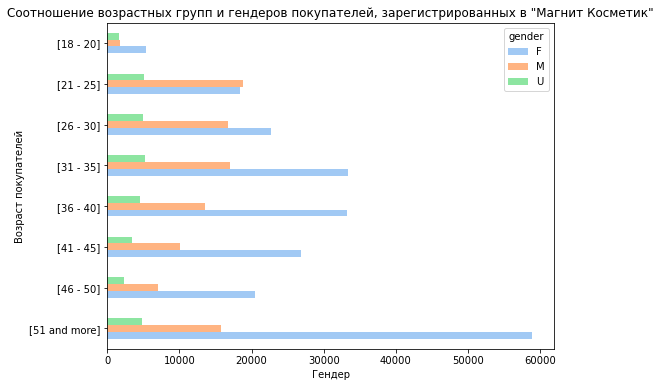

In [68]:
# половозрастное распределение покупателей системы "Магнит Косметик"
report = customers.pivot_table(index = 'customer_age_group', columns = 'gender', values = 'customer', aggfunc = 'nunique')
report['total'] = report['F'] + report['M']+ report['U']
report = report.sort_values('customer_age_group', ascending = False)
display(report)
report[['F', 'M', 'U']].plot(kind = 'barh', figsize = (8, 6))
plt.ylabel("Возраст покупателей")
plt.xlabel("Гендер")
plt.title ('Соотношение возрастных групп и гендеров покупателей, зарегистрированных в "Магнит Косметик"')

Графики практически идентичны. Это означает, что половозрастной состав покупателей, у которых в чеке есть хотя бы один товар P&G, не отличаются от общего половозрастного состава покупателей магазина "Магнит-косметик". Мы также можем отметить, что абсолютное численное выражаение покупающих P&G не сильно отличается от общего числа зарегистрированных в магните. Это значит, что подавляющее число зарегистрированных в системе "Магнит Косметик" покупают или покупали продукцию P&G.

Мы посмотрели частоту покупок, а какие половозрастные группы покупают больше товаров? По графикам боксплот и информации о квартилях данных мы можем увидеть, что в 25% - 3 и больше товара P&G. Посмотрим, в чьих чеках мы чаще всего можем увидеть больше трех товаров P&G. 

In [69]:
# вычленим айди тех покупателей, которые в течении года купили больше 3 товаров P&G в одном чеке
oftencus = checks.loc[checks['product'] > 3]
oftencust = checks.loc[checks['product'] > 3, "customer"] 

In [70]:
# посчитаем число уникальных покупателей продукции P&G по их половозрастному составу (те, кто купили больше 3 товаров). для этого вычленим из нашей таблицы с чеками только уникальных покупателей
checksunof = pd.DataFrame(oftencust.unique())
checksunof.columns = ['customer']
checksunof = checksunof.merge(right = customers, on='customer', how='left') 

In [71]:
checksunof.count()

customer              251708
customer_age_group    251278
gender                251278
enr_channel           251278
enr_date              251278
dtype: int64

gender,F,M,U,total
customer_age_group,,,,
[51 and more],43601,8883,3206,55690
[46 - 50],15624,4162,1612,21398
[41 - 45],20937,6293,2387,29617
[36 - 40],26464,8479,3299,38242
[31 - 35],26550,10615,3754,40919
[26 - 30],17702,10508,3415,31625
[21 - 25],13347,11871,3409,28627
[18 - 20],3458,750,952,5160


Text(0.5, 1.0, "Соотношение возрастных групп и гендеров покупателей p&g продуктов (купили больше трех продуктов) в 'Магнит Косметик'")

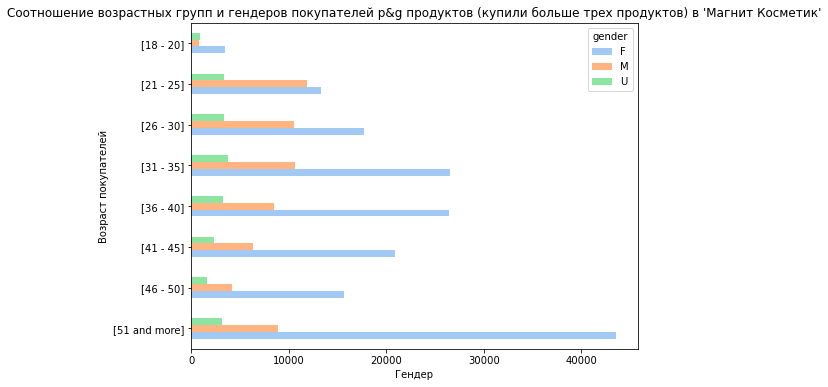

In [72]:
report = checksunof.pivot_table(index = 'customer_age_group', columns = 'gender', values = 'customer', aggfunc = 'nunique')
report['total'] = report['F'] + report['M']+ report['U']
report = report.sort_values('customer_age_group', ascending = False)
display(report)
report[['F', 'M', 'U']].plot(kind = 'barh', figsize = (8, 6))
plt.ylabel("Возраст покупателей")
plt.xlabel("Гендер")
plt.title ("Соотношение возрастных групп и гендеров покупателей p&g продуктов (купили больше трех продуктов) в 'Магнит Косметик'")

Покупатели больше 3х товаров в магазине косметики не отличаются от среднего покупателя в "Магнит Косметик" и среднего покупателя P&G товаров. Что чаще всего покупают эти люди?  

In [73]:
checksunofag = checksunof['customer']

In [74]:
# требуется слишком много памяти, чтобы открыть таблицу (и полностью посмотреть информацию), необходимо сократить: 
minimdata = data.iloc[0:13600000:100]
oftenchechpur = minimdata.query('customer in @checksunofag')


In [75]:
oftenchechpur['product'].value_counts().head(10)

Туалетная бумага                   5543
Хозяйственные товары для уборки    4231
Пасты зубные                       3672
Влажные корма для кошек и котят    3163
Шампуни                            3039
Чулочно-носочные изделия           2922
Влажные салфетки                   2890
Ватная продукция                   2829
Краска для волос                   2790
Чистящие средства                  2711
Name: product, dtype: int64

Чаще всего покупатели, которые покупали больше 3 товаров P&G в одном чеке, покупают топ-5:   
Туалетная бумага, Хозяйственные товары для уборки, Пасты зубные, Влажные корма для кошек и котят, Шампуни. Эти показатели практически не отличается от среднего покупателя.              

Также посмотрим, как покупательская способность меняется в течение года, и сколько в среднем товаров P&G приобретается каждый месяц. 

In [76]:
checks['month'] = checks['purchase date'].dt.month

In [77]:
# для того, чтобы сократить время обработки данных, сократим данные, сохраняя баланс: 
mindata = checks.iloc[0:4042000:10]

<AxesSubplot:xlabel='month', ylabel='total'>

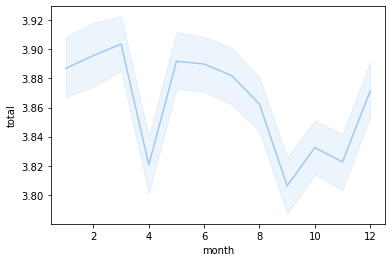

In [78]:
sns.lineplot(data=mindata, x="month", y="total", estimator=np.mean)

Мы видим небольшое проседание на 0.08 пунктов среднего количества всех покупок в чеке в апреле, медленное падение с мая по сентябрь. Сентябрь представляется мксяцев, когда среднее количество покупок в чеке падает сильнее всего в течение года. Пик покупок приходятся на март.

Эта картинка сохраняется и в отношении товаров от P&G, а не по общему чеку. 

<AxesSubplot:xlabel='month', ylabel='product'>

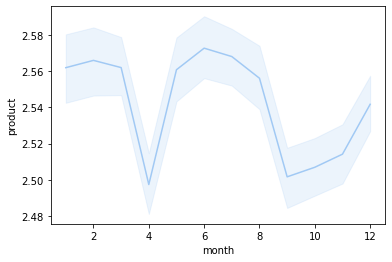

In [79]:
sns.lineplot(data=mindata, x="month", y="product", estimator=np.mean)

Найдем распределение покупателей по количеству соверешенных покупок за год. 

In [80]:
countyear = checks.groupby('customer').agg({'purchase date':'count'})

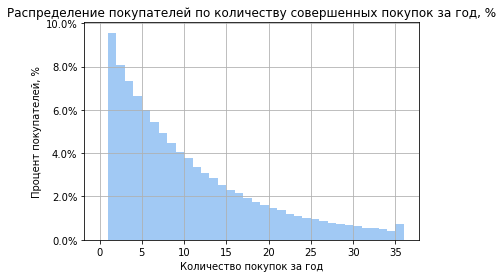

In [81]:
plt.hist(countyear['purchase date'], weights=np.ones(len(countyear['purchase date'])) / len(countyear['purchase date']), range = (0, 20),bins=[0, 1, 2, 3, 4, 5, 6,7,8,9,10, 11, 12, 13, 14,15, 16,17,18,19,20, 21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36])
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Распределение покупателей по количеству совершенных покупок за год, %')
plt.xlabel("Количество покупок за год")
plt.ylabel("Процент покупателей, %")
plt.show()


Мы можем заметить, что 9% покупателей купили продукты(ы) P&G только один раз.

In [82]:
countyear['purchase date'].quantile([0.01, 0.25, 0.5, 0.75, 0.95, 0.99])

0.01     1.0
0.25     4.0
0.50     8.0
0.75    16.0
0.95    36.0
0.99    59.0
Name: purchase date, dtype: float64

Покупателей, которые в течении года совершили покупку больше 36 раз можно считать выбросами. 50% покутелей совершают 8 и более покупок в магазине в течение года. 

Что чаще всего покупают покупатели, которые затем не возвращаются за повторными покупками в магазин? 

In [83]:
rearcust = countyear[countyear['purchase date'] == 1]

In [84]:
rearcust = rearcust.merge(right = purchases, on='customer', how='left') 

In [85]:
rearcust['product'].value_counts().sort_values(ascending = False).head(30) 

Туалетная бумага                           5999
Пасты зубные                               5720
Хозяйственные товары для уборки            5700
Шампуни                                    5193
Чистящие средства                          4121
Дезодоранты женские                        4041
Ватная продукция                           4028
Чулочно-носочные изделия                   3516
Влажные салфетки                           3511
Женские гели                               3476
Мыло жидкое                                3329
Мыло кусковое                              3239
Краска для волос                           3098
Ополаскиватели для белья                   2946
Дезинфицирующие средства для сантехники    2600
Для глаз                                   2416
Для губ                                    2407
Блоки для унитаза                          2358
Зубные щетки и насадки                     2322
Маски для лица                             2294
Бальзамы и кондиционеры                 

Покупатели, которые зашли купить товары (купили товар(ы) P&G) и больше не возвращались, покупают самые популярные товары, не отличаются от среднего покупателя. Топ-5 товаров в среднем для покупателей в магазине "Магнит Косметик" (по всем чекам): 
Туалетная бумага, Хозяйственные товары для уборки, Пасты зубные, Влажные корма для кошек и котят, Шампуни, Чулочно-носочные изделия. 
Топ-5 товаров для тех, кто купил в Магнит Косметик один раз (в чеке был товар P&G):Туалетная бумага, Хозяйственные товары для уборки, Пасты зубные, Шампуни, Краска для волос.      

Что чаще всего покупают покупатели, которые покупают товары в магазине не меньше 8 раз в год? 

In [86]:
oftendcust = countyear[countyear['purchase date'] >= 8]

In [87]:
oftendcust = oftendcust.merge(right = purchases, on='customer', how='left') 

In [88]:
oftendcust['product'].value_counts().sort_values(ascending = False).head(30) 

Туалетная бумага                           512372
Хозяйственные товары для уборки            378112
Пасты зубные                               319854
Влажные корма для кошек и котят            314453
Шампуни                                    262421
Чулочно-носочные изделия                   259147
Краска для волос                           252587
Ватная продукция                           250606
Влажные салфетки                           249684
Дезодоранты женские                        240282
Чистящие средства                          234347
Мыло жидкое                                210752
Сухие корма для кошек и котят              198689
Мыло кусковое                              194094
Бумажные салфетки                          176563
Женские гели                               175614
Ополаскиватели для белья                   167222
Прокладки                                  162315
Для глаз                                   156875
Для губ                                    151150


И снова мы видим, что список популяных товаров частых покупателей не сильно отличается от списка популярных товаров среднего покупателя. 

Выделим "золотых" покупателей: то есть тех, кто закупался за год больше 8 раз, и у кого в чеке хотя бы раз было больше 3 товаров от P&G.

In [89]:
goldenone = oftendcust.query('customer in @checksunofag')

In [90]:
goldenone['product'].value_counts().sort_values(ascending = False).head(30)  

Туалетная бумага                           494420
Хозяйственные товары для уборки            367462
Пасты зубные                               307773
Влажные корма для кошек и котят            298502
Шампуни                                    252450
Чулочно-носочные изделия                   250867
Ватная продукция                           243745
Влажные салфетки                           242959
Краска для волос                           238692
Дезодоранты женские                        231297
Чистящие средства                          226398
Мыло жидкое                                204644
Сухие корма для кошек и котят              188683
Мыло кусковое                              186508
Бумажные салфетки                          172378
Женские гели                               170902
Ополаскиватели для белья                   162492
Прокладки                                  155606
Для глаз                                   150622
Для губ                                    145395


"Золотые" покупатели также чаще всего покупают туалетную бумагу, товары для уборки, зубные пасты, корма для кошек, шампуни.

In [91]:
goldenone = goldenone.merge(right = customers, on='customer', how='left')

gender,F,M,U,total
customer_age_group,,,,
[51 and more],29495,5226,2026,36747
[46 - 50],10784,2389,1053,14226
[41 - 45],14597,3651,1487,19735
[36 - 40],18624,4742,2108,25474
[31 - 35],18146,5633,2363,26142
[26 - 30],11629,5385,2041,19055
[21 - 25],8362,6029,1965,16356
[18 - 20],2018,339,535,2892


Text(0.5, 1.0, "Соотношение возрастных групп и гендеров 'золотых' покупателей p&g продуктов (купили больше трех продуктов, закупались чаще 8 раз в год) в 'Магнит Косметик'")

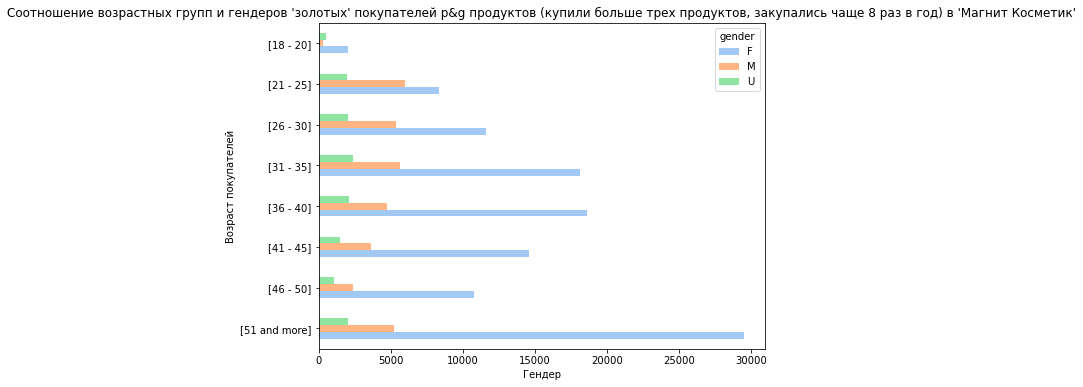

In [92]:
report = goldenone.pivot_table(index = 'customer_age_group', columns = 'gender', values = 'customer', aggfunc = 'nunique')
report['total'] = report['F'] + report['M']+ report['U']
report = report.sort_values('customer_age_group', ascending = False)
display(report)
report[['F', 'M', 'U']].plot(kind = 'barh', figsize = (8, 6))
plt.ylabel("Возраст покупателей")
plt.xlabel("Гендер")
plt.title ("Соотношение возрастных групп и гендеров 'золотых' покупателей p&g продуктов (купили больше трех продуктов, закупались чаще 8 раз в год) в 'Магнит Косметик'")

Возможно существует разница между популярными товарами у мужчин и женщин? Посмотрим популярные товары у "золотых" клиентов и клиенток. 

In [93]:
#goldenone

In [94]:
# топ-10 покупки мужчин
goldoneman = goldenone[goldenone['gender'] == 'M'] 
goldoneman['product'].value_counts().head(10)

Туалетная бумага                   102203
Хозяйственные товары для уборки     75159
Пасты зубные                        63615
Влажные корма для кошек и котят     52548
Шампуни                             45600
Чистящие средства                   44286
Влажные салфетки                    44272
Ватная продукция                    42844
Чулочно-носочные изделия            40684
Мыло кусковое                       40053
Name: product, dtype: int64

In [95]:
# топ-10 покупок женщин
goldonewoman = goldenone[goldenone['gender'] == 'F'] 
goldonewoman['product'].value_counts().head(10)

Туалетная бумага                   352891
Хозяйственные товары для уборки    262295
Влажные корма для кошек и котят    223659
Пасты зубные                       219752
Чулочно-носочные изделия           190073
Шампуни                            184849
Краска для волос                   182133
Ватная продукция                   181174
Влажные салфетки                   178911
Дезодоранты женские                176640
Name: product, dtype: int64

# 4. Кросс-категорийные продажи P&G 

Создадим общую таблицу по всем чекам всех покупателей. 

In [96]:
#data

In [97]:
# данный объем данных выбран из-за ограничений персональных компьютеров аналитиков, работающих над этим проектом 
mindata = data.iloc[0:10000000:50]

In [98]:
groupgoods = mindata.groupby(['customer', 'product']).agg({'product': 'nunique'}).unstack().reset_index(drop = True).fillna(0)

In [99]:
groupgoods.columns = groupgoods.columns.droplevel(0)

In [100]:
#groupgoods.head(30)

In [101]:
total_item_count = sum(groupgoods.sum())
print(total_item_count)
item_summary_df = groupgoods.sum().sort_values(ascending = False).reset_index().head(n=20)
item_summary_df.rename(columns={item_summary_df.columns[0]:'item_name',item_summary_df.columns[1]:'item_count'}, inplace=True)
item_summary_df.head(10)

195149.0


,item_name,item_count
0,Туалетная бумага,8579.0
1,Хозяйственные товары для уборки,6605.0
2,Пасты зубные,5848.0
3,Шампуни,4952.0
4,Чулочно-носочные изделия,4632.0
5,Ватная продукция,4625.0
6,Краска для волос,4518.0
7,Влажные корма для кошек и котят,4490.0
8,Влажные салфетки,4430.0
9,Дезодоранты женские,4312.0


Text(0.5, 1.0, 'Самые часто покупаемые товары')

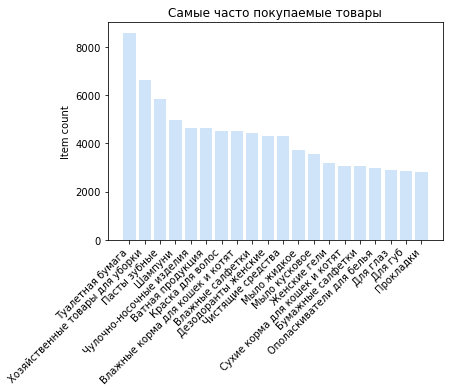

In [102]:
objects = (list(item_summary_df['item_name'].head(n=20)))
y_pos = np.arange(len(objects))
performance = list(item_summary_df['item_count'].head(n=20))
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Item count')
plt.title('Самые часто покупаемые товары')

In [103]:
item_summary_df['item_perc'] = item_summary_df['item_count']/total_item_count
item_summary_df['total_perc'] = item_summary_df.item_perc.cumsum()
item_summary_df.head(10)

,item_name,item_count,item_perc,total_perc
0,Туалетная бумага,8579.0,0.043961,0.043961
1,Хозяйственные товары для уборки,6605.0,0.033846,0.077807
2,Пасты зубные,5848.0,0.029967,0.107774
3,Шампуни,4952.0,0.025375,0.133150
4,Чулочно-носочные изделия,4632.0,0.023736,0.156885
5,Ватная продукция,4625.0,0.023700,0.180585
6,Краска для волос,4518.0,0.023152,0.203737
7,Влажные корма для кошек и котят,4490.0,0.023008,0.226745
8,Влажные салфетки,4430.0,0.022701,0.249445
9,Дезодоранты женские,4312.0,0.022096,0.271541


In [104]:
def clean_data (x):
    if x <= 0: 
        return 0
    if x >= 0:
        return 1
    
groupgoods = groupgoods.applymap(clean_data)    

In [105]:
# groupgoods 

In [106]:
groupgoods = groupgoods.astype('uint8')

In [107]:
md=mlxtend.frequent_patterns.apriori(groupgoods)
md_minsup=mlxtend.frequent_patterns.apriori(groupgoods,
                                           min_support=0.001, 
                                            use_colnames=True)
md_minsup.head(20)

,support,itemsets
0,0.005573,(Автоматические освежители воздуха)
1,0.001102,(Автохимия и косметика)
2,0.010580,(Аксессуары для волос)
3,0.009867,(Аксессуары для гигиены тела)
4,0.003362,(Аксессуары для детей)
5,0.001199,(Аксессуары для обуви)
6,0.001061,(Аксессуары для телефонов и планшетов)
7,0.001717,(Аксессуары и посуда для кормления)
8,0.002568,(Антисептики)
9,0.012556,(Аэрозольные освежители воздуха)


In [108]:
rules=mlxtend.frequent_patterns.association_rules(
md_minsup, metric="confidence",min_threshold=0.0001,support_only=False)

In [109]:
#rules 

In [110]:
# общие данные по всем чекам отсортированы по confidence
rulescon = rules.sort_values(by = 'confidence', ascending = False)
rulescon.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
34,(Сухие корма для кошек и котят),(Влажные корма для кошек и котят),0.024667,0.036372,0.003743,0.151724,4.171400,0.002845,1.135984
35,(Влажные корма для кошек и котят),(Сухие корма для кошек и котят),0.036372,0.024667,0.003743,0.102895,4.171400,0.002845,1.087201
3,(Бумажные полотенца),(Туалетная бумага),0.015197,0.069497,0.001304,0.085821,1.234895,0.000248,1.017857
9,(Бумажные салфетки),(Туалетная бумага),0.024643,0.069497,0.001977,0.080210,1.154164,0.000264,1.011648
119,(Хозяйственные товары для уборки),(Туалетная бумага),0.053506,0.069497,0.003848,0.071915,1.034803,0.000129,1.002606
107,(Прокладки ежедневные),(Туалетная бумага),0.017271,0.069497,0.001223,0.070826,1.019123,0.000023,1.001430
117,(Упаковка для выпечки и хранения продуктов),(Туалетная бумага),0.014849,0.069497,0.001037,0.069831,1.004811,0.000005,1.000359
37,(Влажные корма для кошек и котят),(Туалетная бумага),0.036372,0.069497,0.002446,0.067261,0.967826,-0.000081,0.997603
5,(Бумажные полотенца),(Хозяйственные товары для уборки),0.015197,0.053506,0.001013,0.066631,1.245311,0.000199,1.014063
113,(Сухие корма для кошек и котят),(Туалетная бумага),0.024667,0.069497,0.001636,0.066338,0.954555,-0.000078,0.996617


In [111]:
# отсортированно по support
#rulessup = rules.sort_values(by = 'support', ascending = False)
#rulessup.head(10)

In [112]:
#rulescon = rules.sort_values(by = 'conviction', ascending = False)
#rulescon.head(10)

Посчитаем эту же таблицу кросс-продаж для "золотых покупателей", для мужчин и женщин.  

Для "золотых" мужчин:

In [113]:
goldoneman = goldoneman.iloc[0:2000000:20]

In [114]:
goldoneman.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96418 entries, 0 to 10493261
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer            96418 non-null  object        
 1   purchase date_x     96418 non-null  int64         
 2   index               96418 non-null  int64         
 3   purchase date_y     96418 non-null  datetime64[ns]
 4   product             96418 non-null  object        
 5   other_product       96418 non-null  int32         
 6   p&g_product         96418 non-null  int32         
 7   cost_product        96418 non-null  float64       
 8   cost_p&g            669 non-null    float64       
 9   product_segment     96418 non-null  int32         
 10  p&g_segment         669 non-null    float64       
 11  customer_age_group  96418 non-null  object        
 12  gender              96418 non-null  object        
 13  enr_channel         96418 non-null  object 

In [115]:
groupgoodsgman = goldoneman.groupby(['customer', 'product']).agg({'product': 'nunique'}).unstack().reset_index(drop = True).fillna(0)

In [116]:
groupgoodsgman.columns = groupgoodsgman.columns.droplevel(0)

In [117]:
total_item_count = sum(groupgoodsgman.sum())
print(total_item_count)
item_summary_df = groupgoodsgman.sum().sort_values(ascending = False).reset_index().head(n=20)
item_summary_df.rename(columns={item_summary_df.columns[0]:'item_name',item_summary_df.columns[1]:'item_count'}, inplace=True)
item_summary_df.head(10)

90029.0


,item_name,item_count
0,Туалетная бумага,4469.0
1,Хозяйственные товары для уборки,3368.0
2,Пасты зубные,2898.0
3,Шампуни,2156.0
4,Чистящие средства,2149.0
5,Ватная продукция,2019.0
6,Влажные салфетки,1938.0
7,Чулочно-носочные изделия,1920.0
8,Мыло жидкое,1849.0
9,Мыло кусковое,1842.0


Text(0.5, 1.0, 'Самые часто покупаемые товары "золотыми" мужчинами')

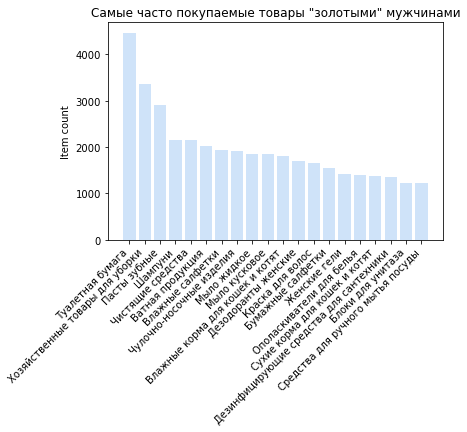

In [118]:
objects = (list(item_summary_df['item_name'].head(n=20)))
y_pos = np.arange(len(objects))
performance = list(item_summary_df['item_count'].head(n=20))
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Item count')
plt.title('Самые часто покупаемые товары "золотыми" мужчинами')

In [119]:
groupgoodsgman = groupgoodsgman.applymap(clean_data)    

In [120]:
groupgoodsgman = groupgoodsgman.astype('uint8')

In [121]:
md=mlxtend.frequent_patterns.apriori(groupgoodsgman)
md_minsup=mlxtend.frequent_patterns.apriori(groupgoodsgman,
                                           min_support=0.001, 
                                            use_colnames=True)
md_minsup.head(20)

,support,itemsets
0,0.010652,(Автоматические освежители воздуха)
1,0.002784,(Автохимия и косметика)
2,0.015858,(Аксессуары для волос)
3,0.015616,(Аксессуары для гигиены тела)
4,0.005417,(Аксессуары для детей)
5,0.002028,(Аксессуары для обуви)
6,0.001967,(Аксессуары для телефонов и планшетов)
7,0.002693,(Аксессуары и посуда для кормления)
8,0.004630,(Антисептики)
9,0.023333,(Аэрозольные освежители воздуха)


In [122]:
rulesgoldman = mlxtend.frequent_patterns.association_rules(
md_minsup, metric="confidence",min_threshold=0.0001,support_only=False)

In [123]:
#rulesgoldman

In [124]:
# таблица для "золотых" покупателей-мужчин,отсортирована по confidence 
rulesgoldmanсon = rulesgoldman.sort_values(by = 'confidence', ascending = False)
rulesgoldmanсon.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1780,"(Бумажные полотенца, Бумажные салфетки)",(Туалетная бумага),0.002512,0.135244,0.001180,0.469880,3.474312,0.000841,1.631244
1922,"(Сухие корма для кошек и котят, Шампуни)",(Влажные корма для кошек и котят),0.002451,0.054866,0.001029,0.419753,7.650480,0.000894,1.628848
2008,"(Средства для ручного мытья посуды, Мыло жидкое)",(Туалетная бумага),0.002875,0.135244,0.001089,0.378947,2.801955,0.000701,1.392404
1905,"(Туалетная бумага, Сухие корма для кошек и котят)",(Влажные корма для кошек и котят),0.006446,0.054866,0.002360,0.366197,6.674363,0.002007,1.491211
1916,"(Сухие корма для кошек и котят, Чулочно-носочн...",(Влажные корма для кошек и котят),0.002845,0.054866,0.001029,0.361702,6.592435,0.000873,1.480710
480,(Лакомства для кошек и котят),(Влажные корма для кошек и котят),0.004025,0.054866,0.001453,0.360902,6.577857,0.001232,1.478856
1816,"(Бумажные салфетки, Мыло жидкое)",(Туалетная бумага),0.003692,0.135244,0.001301,0.352459,2.606099,0.000802,1.335446
1786,"(Бумажные полотенца, Ватная продукция)",(Туалетная бумага),0.002935,0.135244,0.001029,0.350515,2.591728,0.000632,1.331450
1792,"(Хозяйственные товары для уборки, Бумажные пол...",(Туалетная бумага),0.005145,0.135244,0.001785,0.347059,2.566170,0.001090,1.324401
1846,"(Чулочно-носочные изделия, Бумажные салфетки)",(Туалетная бумага),0.003147,0.135244,0.001059,0.336538,2.488381,0.000634,1.303400


In [125]:
# таблица для "золотых" покупателей-мужчин,отсортирована по support
#rulesgoldmansup = rulesgoldman.sort_values(by = 'support', ascending = False)
#rulesgoldmansup.head(10)

Для "золотых" женщин:

In [126]:
goldonewoman = goldonewoman.iloc[0:8000000:80]

In [127]:
groupgoodsgwoman = goldonewoman.groupby(['customer', 'product']).agg({'product': 'nunique'}).unstack().reset_index(drop = True).fillna(0)

In [128]:
groupgoodsgwoman.columns = groupgoodsgwoman.columns.droplevel(0)

In [129]:
total_item_count = sum(groupgoodsgwoman.sum())
print(total_item_count)
item_summary_df = groupgoodsgwoman.sum().sort_values(ascending = False).reset_index().head(n=20)
item_summary_df.rename(columns={item_summary_df.columns[0]:'item_name',item_summary_df.columns[1]:'item_count'}, inplace=True)
item_summary_df.head(10)

95007.0


,item_name,item_count
0,Туалетная бумага,4290.0
1,Хозяйственные товары для уборки,3239.0
2,Пасты зубные,2765.0
3,Влажные корма для кошек и котят,2601.0
4,Шампуни,2334.0
5,Чулочно-носочные изделия,2320.0
6,Ватная продукция,2312.0
7,Краска для волос,2273.0
8,Влажные салфетки,2206.0
9,Дезодоранты женские,2170.0


Text(0.5, 1.0, 'Самые часто покупаемые товары "золотыми" женщинами')

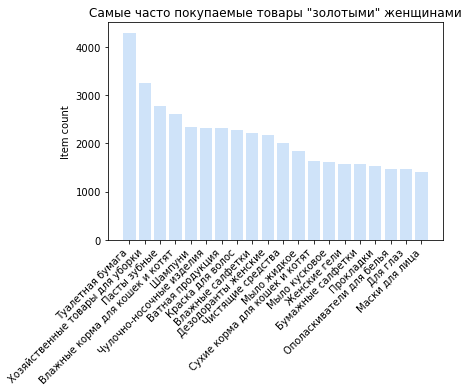

In [130]:
objects = (list(item_summary_df['item_name'].head(n=20)))
y_pos = np.arange(len(objects))
performance = list(item_summary_df['item_count'].head(n=20))
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Item count')
plt.title('Самые часто покупаемые товары "золотыми" женщинами')

In [131]:
groupgoodsgwoman = groupgoodsgwoman.applymap(clean_data)    
groupgoodsgwoman = groupgoodsgwoman.astype('uint8')

In [132]:
md=mlxtend.frequent_patterns.apriori(groupgoodsgwoman)
md_minsup=mlxtend.frequent_patterns.apriori(groupgoodsgwoman,
                                           min_support=0.001, 
                                            use_colnames=True)
md_minsup.head(20)

,support,itemsets
0,0.004252,(Автоматические освежители воздуха)
1,0.008191,(Аксессуары для волос)
2,0.007092,(Аксессуары для гигиены тела)
3,0.002761,(Аксессуары для детей)
4,0.001099,(Аксессуары и посуда для кормления)
5,0.001766,(Антисептики)
6,0.008754,(Аэрозольные освежители воздуха)
7,0.014615,(Бальзамы и кондиционеры)
8,0.004815,(Батарейки)
9,0.016199,(Блоки для унитаза)


In [133]:
rulesgoldwoman = mlxtend.frequent_patterns.association_rules(
md_minsup, metric="confidence",min_threshold=0.0001,support_only=False)

In [134]:
# связи по "золотым" женщинам
rulesgoldwoman

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Сухие корма для кошек и котят),(Влажные корма для кошек и котят),0.021315,0.034033,0.002198,0.103131,3.030323,0.001473,1.077043
1,(Влажные корма для кошек и котят),(Сухие корма для кошек и котят),0.034033,0.021315,0.002198,0.064591,3.030323,0.001473,1.046264
2,(Туалетная бумага),(Влажные корма для кошек и котят),0.056133,0.034033,0.001413,0.025175,0.739720,-0.000497,0.990913
3,(Влажные корма для кошек и котят),(Туалетная бумага),0.034033,0.056133,0.001413,0.041522,0.739720,-0.000497,0.984757
4,(Туалетная бумага),(Хозяйственные товары для уборки),0.056133,0.042381,0.001400,0.024942,0.588514,-0.000979,0.982115
5,(Хозяйственные товары для уборки),(Туалетная бумага),0.042381,0.056133,0.001400,0.033035,0.588514,-0.000979,0.976113
